In [2]:
#pip install ucimlrepo-- UNCOMMENT


Note: you may need to restart the kernel to use updated packages.


In [3]:
#!pip install prettytable

In [5]:
#pip install pandas-- UNCOMMENT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.6 MB/s eta 0:00:00m eta 0:00:01:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 18.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 9.0 MB/s eta 0:00:00m eta 0:00:01
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
#pip install scikit-learn-- UNCOMMENT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.5 MB/s eta 0:00:00m eta 0:00:01:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 16.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# WE CAN ADD SOME INTRO/BACKGROUND FROM THIS PAPER 

# https://academic.oup.com/gigascience/article/9/11/giaa128/6006352 



Relevant snippet copied from paper:

Previously, the dataset was a subject of machine learning method applications, including convolutional neural networks [23] and dimensionality reduction methods [24].


As a first step of pre-processing, 7 variables were removed from the initial MI complication data table as containing >30% of missing values. Next, 126 records were removed as containing >20% of the missing values. After this step, the data table contained 2.5% of missing values with 533 rows (34% of all clinical cases) having no missing values.

After the missing value filtering step, the data table of MI complications contained 84 binary, 9 continuous numerical, 22 ordinal, and 1 categorical variables. The large number of ordinal variables requires careful quantification (see Methods), which is not trivial given the large number of rows with missing values.

We considered the number of continuous numerical variables too small to apply the methodology of categorical principal component analysis (CatPCA) [28]. Therefore, for all ordinal and binary variables we first applied univariate quantification following the approach described in the Methods section. This quantification allowed the application of the “SVDComplete" imputation method for imputing the missing values, as described in the Methods. After all missing values were imputed, we could apply the optimal scaling approach for ordinal values, optimizing the pairwise correlations between them and between ordinal and continuous numerical variables. The 22 ordinal variables quantified in this way were further used for forming the data space. In addition, all variables were converted to z-scores.


Note: features already ordinally encoded

# Setup

In [1]:
# READ IN DATA AND IMPORT RELEVANT PACKAGES

from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from prettytable import PrettyTable
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight


  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
X = myocardial_infarction_complications.data.features 
y = myocardial_infarction_complications.data.targets 


In [2]:
# GET RID OF FEATURES AND OBSERVATIONS WITH A LOT OF MISSINGNESS

# first, find percentage of missing values
missing_percentage = (X.isna().sum() / len(X)) * 100

# List of columns with over 30% missing values
columns_to_remove = missing_percentage[missing_percentage > 30].index
X = X.drop(columns = columns_to_remove)

# we will also remove rows with >20% missingess
missing_percentage_per_row = (X.isna().sum(axis=1) / X.shape[1]) * 100
rows_to_remove = missing_percentage_per_row[missing_percentage_per_row > 20].index

# Remove the identified rows from both X and Y
X = X.drop(index=rows_to_remove)
y = y.drop(index=rows_to_remove)

# TODO: Explain this process in milestone and report the percentage of missingness in the dataframe, how many features were removed, etc.

In [3]:
# CREATE NEW OUTCOME THAT IS 1 IF ANY EVENT OCCURS AND 0 IF NO EVENT OCCURS
events = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
       'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']
y['any_event'] = y[events].any(axis=1).astype(int)


# CREATE NEW OUTCOME THAT GROUPS CAUSES OF DEATH TOGETHER SO WE HAVE LESS OUTCOMES
# INSPO FROM CHATGPT (SEE BELOW)

def map_to_category(cause):
    if cause in [1, 3, 4]:
        return 'cardiac_complications'
    elif cause in [2, 5]:
        return 'pulmonary_complications'
    elif cause in [6, 7]:
        return 'cardiac_arrest'
    else:
        return 'alive' 

y['cause_of_death'] = y['LET_IS'].apply(map_to_category)

In [4]:
# SPLIT DATA INTO TRAIN AND TEST

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# Determine which features are categorical (ordinal), continuous, and binary
# might be helpful later

unique_non_missing_values = X.nunique(dropna=True)
unique_non_missing_values_df = unique_non_missing_values.reset_index()
unique_non_missing_values_df.columns = ['feature', 'n_unique_values']


continuous_features = ['AGE', 'D_AD_ORIT', 'S_AD_ORIT', 'K_BLOOD', 
                       'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 
                       'ROE']

binary_features = list(unique_non_missing_values_df[(unique_non_missing_values_df['n_unique_values'] == 2) & (~unique_non_missing_values_df['feature'].isin(continuous_features))]['feature'])

ordinal_features = list(unique_non_missing_values_df[(unique_non_missing_values_df['n_unique_values'] > 2) & (~unique_non_missing_values_df['feature'].isin(continuous_features))]['feature'])


# TODO: Note in paper that we split our data into training and testing

In [5]:
# CHECK BALANCE IN TRAIN AND TEST SPLITS FOR 'ANY_EVENT' OUTCOME

print(sum(y_train['any_event'])/len(y_train))
print(sum(y_test['any_event'])/len(y_test))

# Both around 50%! We probably do not need to rebalance for the binary classification task


# CHECK BALANCE IN TRAIN AND TEST SPLITS FOR 'CAUSE OF DEATH' OUTCOME
print(y_train['LET_IS'].value_counts(normalize=True))
print(y_test['LET_IS'].value_counts(normalize=True))

# we see a much greater degree of imbalance in this column, with around 85% 
# alive outcomes and only 15% being any other cause of death

# TODO: In paper note the degree of balance/imbalance in all of our possible outcomes
# TODO: Make these into nice tables for the paper 

0.5406392694063927
0.5574468085106383
LET_IS
0    0.852055
1    0.054795
3    0.028311
7    0.018265
6    0.014612
4    0.012785
2    0.010959
5    0.008219
Name: proportion, dtype: float64
LET_IS
0    0.825532
1    0.070213
3    0.046809
6    0.014894
4    0.014894
7    0.010638
2    0.010638
5    0.006383
Name: proportion, dtype: float64


In [6]:
# For individual outcomes, want to look at proportion of outcome vs. no outcome as well
y_outcomes = y_train[events]
proportions = (y_outcomes.sum() / len(y_outcomes)).round(2)  
print(proportions)

# TODO: Report this in fancy table in paper
# Also include a table that shows the number/proportion of overlaps between these

FIBR_PREDS    0.10
PREDS_TAH     0.01
JELUD_TAH     0.03
FIBR_JELUD    0.05
A_V_BLOK      0.03
OTEK_LANC     0.10
RAZRIV        0.03
DRESSLER      0.04
ZSN           0.24
REC_IM        0.08
P_IM_STEN     0.08
dtype: float64


In [7]:
# IMPUTE MISSING VALUES ON TRAINING AND TESTING DATA
# using simple KNN imputer for now

def impute_values(X, n):
    imputer = KNNImputer(n_neighbors=n)
    imputed = imputer.fit_transform(X)
    return imputed

# Fit the imputer on the training data and transform train and test data
X_train_imputed = impute_values(X_train, 5)
X_test_imputed = impute_values(X_test, 5)

#TODO: Explain this simple process in paper and note that without more knowledge on missingness we will not explore other methods


# Binary Classification with Logistic Regression

We are predicting the target of any event vs. no event. These are quite balanced outcomes (see percentages above!) so we will not deal with rebalancing the data.

In [8]:
# TRAIN LOGISTIC REGRESSION MODEL WITH LASSO 

# train model
model = LogisticRegression(penalty = "l1", solver='liblinear')
model.fit(X_train_imputed, y_train['any_event'])

# make predictions on test data
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test['any_event'], y_pred)
print(accuracy)
confusion_matrix(y_test['any_event'], y_pred)

# we have accuracy of almost 70% 
# can we format this confusion matrix better?
# we can make note that accuracy feels reasonable to look at here because of class balance



0.6829787234042554


array([[140,  68],
       [ 81, 181]])

In [9]:
# FIGURE OUT WHICH FEATURES REMAINED IN THE MODEL AFTER LASSO

coefficients = model.coef_
feature_names = X_train.columns  
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})
selected_features = feature_coefficients[feature_coefficients['Coefficient'] != 0]
selected_features

# 65 features remain of original 104! 

# TODO: Explain this process in paper and print out classificaiton report
# Note that we will also try this with a deep learning model to see if we can bump up accuracy

,Feature,Coefficient
0,AGE,0.031178
1,SEX,-0.199740
3,STENOK_AN,0.028114
4,FK_STENOK,-0.060183
5,IBS_POST,0.092326
...,...,...
97,LID_S_n,0.313668
99,ANT_CA_S_n,-0.015920
100,GEPAR_S_n,0.141900
101,ASP_S_n,0.008433


# Multi-Class Classification with Logistic Regression

We are now predicting the cause of death outcome, where as you can recall there is a great deal of class imbalance. In the training set 85% of outcomes are alive, while the remainining 15% is split between 7 different options.

In writeup describe what all of these causes are.

We will first try to just run a logistic regression without accounting for class imbalance at all. We will use the l1 regularization again.

There are two options, one v. one and one v. rest. In the OvR strategy, you train a separate binary classifier for each class, treating it as the positive class, while considering all other classes as the negative class.

OvR is often preferred when you have a large number of classes, and it can be more computationally efficient.
It's suitable for imbalanced datasets and is less sensitive to imbalanced class distributions.
OvR can handle both binary and multiclass classification problems without modification. 

We will start with OVR. 





### Crude: No Balancing

In [10]:
# train model
model = LogisticRegression(multi_class='ovr', solver='liblinear', penalty = 'l1')
model.fit(X_train_imputed, y_train['LET_IS'])
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test['LET_IS'], y_pred)
report = classification_report(y_test['LET_IS'], y_pred)

/Users/ashleylewis/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ashleylewis/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ashleylewis/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:

report_data = report.split('\n')
table = PrettyTable(["Category"] + report_data[0].split())
for line in report_data[2:-5]:
    table.add_row(line.split())
print(table)

+----------+-----------+--------+----------+---------+
| Category | precision | recall | f1-score | support |
+----------+-----------+--------+----------+---------+
|    0     |    0.85   |  1.00  |   0.92   |   388   |
|    1     |    0.91   |  0.30  |   0.45   |    33   |
|    2     |    0.00   |  0.00  |   0.00   |    5    |
|    3     |    0.25   |  0.05  |   0.08   |    22   |
|    4     |    0.00   |  0.00  |   0.00   |    7    |
|    5     |    0.00   |  0.00  |   0.00   |    3    |
|    6     |    0.00   |  0.00  |   0.00   |    7    |
|    7     |    0.00   |  0.00  |   0.00   |    5    |
+----------+-----------+--------+----------+---------+


TODO: Figure out which metric we care about in the imbalanced setting??

### Re-Balancing Training Data

We can try this in a few ways ways:

1. Upsampling minority classes
2. Class Weighted Loss

First we will start simple with oversampling minority classes. 

#### Oversampling minority classes

We will oversample minority classes to the size of the original data

In [20]:
class_counts = y_train['LET_IS'].value_counts()
minority_classes = class_counts[class_counts != class_counts.max()].index
columns = list(X_train.columns) + list(y_train.columns)
upsampled_data = pd.DataFrame(columns=columns)
combined_df = pd.DataFrame(np.hstack((X_train_imputed, np.array(y_train))), columns = columns)

for minority_class in minority_classes:
    # Subset the minority class instances
    minority_data = combined_df[combined_df['LET_IS'] == minority_class]

    # Oversample the minority class to match the size of the majority class
    minority_upsampled = resample(minority_data, replace=True, n_samples=class_counts.max(), random_state=42)

    # Add the upsampled data to the DataFrame
    upsampled_data = pd.concat([upsampled_data, minority_upsampled])

# Combine the upsampled data with the majority class data
balanced_data = pd.concat([combined_df[combined_df['LET_IS'] == 0], upsampled_data])

# Separate the features and target variable from the upsampled data
X_train_upsampled = np.array(balanced_data.drop(y_train.columns, axis=1))
y_train_upsampled = balanced_data[y_train.columns]




In [13]:
# train model and make predictions as usual
model = LogisticRegression(multi_class='ovr', solver='liblinear', penalty = 'l1')
model.fit(X_train_upsampled, y_train_upsampled[])
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test['LET_IS'], y_pred)
report = classification_report(y_test['LET_IS'], y_pred)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2013891427.py, line 3)

In [168]:
# our accuracy takes a hit, but we have better recall in four more classes. 
print(accuracy)
report_data = report.split('\n')
table = PrettyTable(["Category"] + report_data[0].split())
for line in report_data[2:-5]:
    table.add_row(line.split())
print(table)

0.6340425531914894
+----------+-----------+--------+----------+---------+
| Category | precision | recall | f1-score | support |
+----------+-----------+--------+----------+---------+
|    0     |    0.92   |  0.71  |   0.80   |   388   |
|    1     |    0.33   |  0.45  |   0.38   |    33   |
|    2     |    0.10   |  0.20  |   0.13   |    5    |
|    3     |    0.10   |  0.18  |   0.12   |    22   |
|    4     |    0.08   |  0.14  |   0.11   |    7    |
|    5     |    0.00   |  0.00  |   0.00   |    3    |
|    6     |    0.00   |  0.00  |   0.00   |    7    |
|    7     |    0.00   |  0.00  |   0.00   |    5    |
+----------+-----------+--------+----------+---------+


#### Reweighting Classes

We can also try to assign different weights to classes to give more importance to minority classes. 

In [14]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train['LET_IS']), y=y_train['LET_IS'])

# Create a dictionary with class weights
class_weight_dict = dict(enumerate(class_weights))

# train model and make predictions as usual
model = LogisticRegression(multi_class='ovr', solver='liblinear', penalty = 'l1', class_weight=class_weight_dict)
model.fit(X_train_imputed, y_train['LET_IS'])
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test['LET_IS'], y_pred)
report = classification_report(y_test['LET_IS'], y_pred)

In [15]:
# our accuracy is better than before, but still poor performance on the smaller classes 
print(accuracy)
report_data = report.split('\n')
table = PrettyTable(["Category"] + report_data[0].split())
for line in report_data[2:-5]:
    table.add_row(line.split())
print(table)

0.7574468085106383
+----------+-----------+--------+----------+---------+
| Category | precision | recall | f1-score | support |
+----------+-----------+--------+----------+---------+
|    0     |    0.91   |  0.87  |   0.89   |   388   |
|    1     |    0.52   |  0.39  |   0.45   |    33   |
|    2     |    0.10   |  0.20  |   0.13   |    5    |
|    3     |    0.22   |  0.23  |   0.22   |    22   |
|    4     |    0.00   |  0.00  |   0.00   |    7    |
|    5     |    0.00   |  0.00  |   0.00   |    3    |
|    6     |    0.00   |  0.00  |   0.00   |    7    |
|    7     |    0.00   |  0.00  |   0.00   |    5    |
+----------+-----------+--------+----------+---------+


### Consolidating Classes


We can also try to consolidate our classes so that we have more manageable outcomes. According to chatgpt:

Cardiac Complications:
Cardiogenic shock (1)
Myocardial rupture (3)
Progress of congestive heart failure (4)
These conditions are all related to the function and complications of the heart. They could be grouped together as "Cardiac Complications."

Pulmonary/Cardiopulmonary Complications:
Pulmonary edema (2)
Thromboembolism (5)
Both of these conditions involve complications in the pulmonary system or the interaction between the heart and the lungs.

Cardiac Arrest:
Asystole (6)
Ventricular fibrillation (7)
Both asystole and ventricular fibrillation are types of cardiac arrest. You could group them together as "Cardiac Arrest."


We will upsample our data according to these four classes.



In [25]:
class_counts = y_train['cause_of_death'].value_counts()
minority_classes = class_counts[class_counts != class_counts.max()].index
columns = list(X_train.columns) + list(y_train.columns)
upsampled_data = pd.DataFrame(columns=columns)
combined_df = pd.DataFrame(np.hstack((X_train_imputed, np.array(y_train))), columns = columns)

for minority_class in minority_classes:
    # Subset the minority class instances
    minority_data = combined_df[combined_df['cause_of_death'] == minority_class]

    # Oversample the minority class to match the size of the majority class
    minority_upsampled = resample(minority_data, replace=True, n_samples=class_counts.max(), random_state=42)

    # Add the upsampled data to the DataFrame
    upsampled_data = pd.concat([upsampled_data, minority_upsampled])

# Combine the upsampled data with the majority class data
balanced_data = pd.concat([combined_df[combined_df['cause_of_death'] == 'alive'], upsampled_data])

# Separate the features and target variable from the upsampled data
X_train_upsampled = np.array(balanced_data.drop(y_train.columns, axis=1))
y_train_upsampled = balanced_data[y_train.columns]


# our accuracy takes a hit, but we have better recall in four more classes. 
# train model and make predictions as usual
model = LogisticRegression(multi_class='ovr', solver='liblinear', penalty = 'l1')
model.fit(X_train_upsampled, y_train_upsampled['cause_of_death'])
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test['cause_of_death'], y_pred)
report = classification_report(y_test['cause_of_death'], y_pred)


In [26]:
class_counts

cause_of_death
alive                      933
cardiac_complications      105
cardiac_arrest              36
pulmonary_complications     21
Name: count, dtype: int64

In [28]:
# understandably, we are still performing poorly on the lower classes, but we should consider the support.
# there are so few observations in these classes still. 
print(accuracy)
report_data = report.split('\n')
table = PrettyTable(["Category"] + report_data[0].split())
for line in report_data[2:-5]:
    table.add_row(line.split())
print(table)

0.6702127659574468
+-------------------------+-----------+--------+----------+---------+
|         Category        | precision | recall | f1-score | support |
+-------------------------+-----------+--------+----------+---------+
|          alive          |    0.94   |  0.73  |   0.82   |   388   |
|      cardiac_arrest     |    0.03   |  0.17  |   0.05   |    12   |
|  cardiac_complications  |    0.38   |  0.45  |   0.41   |    62   |
| pulmonary_complications |    0.04   |  0.12  |   0.06   |    8    |
+-------------------------+-----------+--------+----------+---------+


# Remaining Tasks

1. Write out intro, describing our major problems of interest and what we plan to do to address each of these. 
2. Describe dataset features (time of collection), targets of interest, and initial dataset preprocessing (we should probably look into what these targets actually are)
3. Plots/Tables: Percentage of various outcomes, table showing amount of overlap between possible outcomes, maybe some plots of outcome vs. feature
4. Simple binary classification with logistic regression-- explain how we did lasso for convergence and report confusion matrix (formatted nicely). Say that we have a decent accuracy and that our outcomes are quite balanced here. But we can do better in terms of accuracy and our next steps in the binary classification setting are to explore 
5. Then say that we also have a multi-class classification problem of interest, where imbalance is a much greater problem. Talk about the specific setup and what metrics we will need to use. We have so far tried 1) no rebalancing, 2) upsampling, 3) reweighting, and 4) consolidating classes and upsampling again. So far doesn't look like we do great in any case so this data just might not be ideal. So for our next steps, we are going to turn to either 1) just predicting this as a binary outcome or 2) using multi-label classification to predict multiple outcomes for a patient. For these we will again try simple LR and then move over to deep learning techniue



5. Perhaps converting our 8-class classification to a 3/4 class? I asked chatgpt if there were similarities between the outcomes and 
6. Need to add notes about what we will try regarding deep learning
7. What are next steps? Maybe because of the insufficiency of the cause of death outcome we can switch to predicting individual outcomes in the data with a multi-label classifier. And we can choose a few relevant ones.

And organize everything into:

Motivation: What problem are you tackling, and what's the setting you're considering?
Method: What machine learning techniques have you tried and why?
Preliminary experiments: Describe the experiments that you've run, the outcomes, and any error analysis that you've done. You should have tried at least one baseline.
Next steps: Given your preliminary results, what are the next steps that you're considering?


# Neural Network Setup: Binary Classification and Multi-Class (Using 5 classes)
### (Using ChatGPT Cross-Referenced w/ External Domain Knowledge)

### Setup Binary NN

In [1]:
# READ IN DATA AND IMPORT RELEVANT PACKAGES

from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from prettytable import PrettyTable
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight


  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
X = myocardial_infarction_complications.data.features 
y = myocardial_infarction_complications.data.targets 


In [23]:
# CREATE NEW OUTCOME THAT IS 1 IF ANY EVENT OCCURS AND 0 IF NO EVENT OCCURS
events = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
       'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']
y['any_event'] = y[events].any(axis=1).astype(int)


/var/folders/fs/rr9_ckw16svd769s2v3xs1rw0000gn/T/ipykernel_25789/3628350368.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['any_event'] = y[events].any(axis=1).astype(int)


"def map_to_5_categories(cause):\n    if cause in [1, 4]:\n        return 1 #cardiac_complications\n    elif cause in [2]:\n        return 2 #pulmonary_edema\n    elif cause in [5]:\n        return 3 #thromboembolism\n    elif cause in [3]: #pulmonary_edema\n        return 4 #asystole\n    elif cause in [7]:\n        return 5 #ventricular_fib\n    else:\n        return 0 #alive \n\ny['cause_of_death'] = y['LET_IS'].apply(map_to_5_categories)"

In [30]:
y = y['any_event']

In [31]:
# SPLIT DATA INTO TRAIN AND TEST

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# Determine which features are categorical (ordinal), continuous, and binary
# might be helpful later

'''unique_non_missing_values = X.nunique(dropna=True)
unique_non_missing_values_df = unique_non_missing_values.reset_index()
unique_non_missing_values_df.columns = ['feature', 'n_unique_values']


#continuous_features = ['AGE', 'D_AD_ORIT', 'S_AD_ORIT', 'K_BLOOD', 
                       #'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 
                       #'ROE']

#binary_features = list(unique_non_missing_values_df[(unique_non_missing_values_df['n_unique_values'] == 2) & (~unique_non_missing_values_df['feature'].isin(continuous_features))]['feature'])

#ordinal_features = list(unique_non_missing_values_df[(unique_non_missing_values_df['n_unique_values'] > 2) & (~unique_non_missing_values_df['feature'].isin(continuous_features))]['feature'])


# TODO: Note in paper that we split our data into training and testing'''

"unique_non_missing_values = X.nunique(dropna=True)\nunique_non_missing_values_df = unique_non_missing_values.reset_index()\nunique_non_missing_values_df.columns = ['feature', 'n_unique_values']\n\n\n#continuous_features = ['AGE', 'D_AD_ORIT', 'S_AD_ORIT', 'K_BLOOD', \n                       #'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', \n                       #'ROE']\n\n#binary_features = list(unique_non_missing_values_df[(unique_non_missing_values_df['n_unique_values'] == 2) & (~unique_non_missing_values_df['feature'].isin(continuous_features))]['feature'])\n\n#ordinal_features = list(unique_non_missing_values_df[(unique_non_missing_values_df['n_unique_values'] > 2) & (~unique_non_missing_values_df['feature'].isin(continuous_features))]['feature'])\n\n\n# TODO: Note in paper that we split our data into training and testing"

In [33]:
y_train.value_counts()

any_event
1    656
0    534
Name: count, dtype: int64

In [34]:
# IMPUTE MISSING VALUES ON TRAINING AND TESTING DATA
# using simple KNN imputer for now

def impute_values(X, n):
    imputer = KNNImputer(n_neighbors=n)
    imputed = imputer.fit_transform(X)
    return imputed

# Fit the imputer on the training data and transform train and test data
X_train_imputed = impute_values(X_train, 5)
X_test_imputed = impute_values(X_test, 5)

#TODO: Explain this simple process in paper and note that without more knowledge on missingness we will not explore other methods

### Baseline NN Model for Binary Classification (lethal outcome v. alive)
*** DO NOT CHANGE ***

In [193]:
import math
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [35]:
x_train = preprocessing.normalize(X_train_imputed)
x_test = preprocessing.normalize(X_test_imputed)

In [113]:
hidden_units = 10     # how many neurons in the hidden layer
activation = 'relu'   # activation function for hidden layer
l2 = 0.01             # regularization - how much we penalize large parameter values
learning_rate = 0.01  # how big our steps are in gradient descent
epochs = 10            # how many epochs to train for
batch_size = 16       # how many samples to use for each gradient descent update

In [172]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=X_train.shape[1]-1,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [38]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [99]:
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
x_train_remove_last = x_train[:,:-1]

Epoch 1/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6542 - accuracy: 0.6202
Epoch 2/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6532 - accuracy: 0.6252
Epoch 3/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.6361
Epoch 4/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.6277
Epoch 5/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6438 - accuracy: 0.6252
Epoch 6/10
75/75 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6277
Epoch 7/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6277 - accuracy: 0.6571
Epoch 8/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6245 - accuracy: 0.6437
Epoch 9/10
75/75 [==============================] - 0s 2ms/step - loss: 0.6225 - accuracy: 0.6647
Epoch 10/10
38/38 [==============================] - 0s 2ms/step - loss: 0.6137 - accuracy: 0.6723
Training accuracy: 

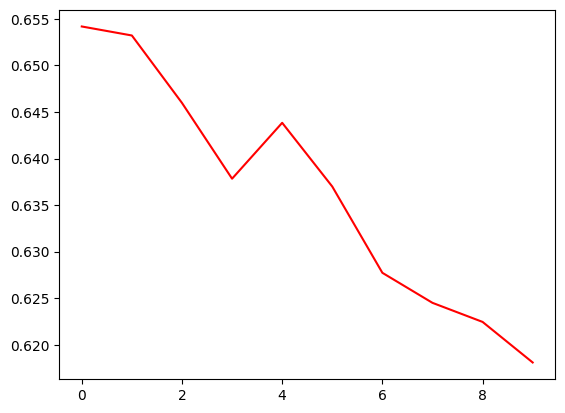

In [116]:
# train the parameters
history = model.fit(x_train_remove_last, y_train, epochs=10, batch_size=batch_size)

# evaluate accuracy
train_acc = model.evaluate(x_train_remove_last, y_train, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()


Baseline NN Model for Binary Classification achieves comparable accuracy for LR binary classification. Now let's see if we can tune hyperparameters to achieve better binary classification accuracy. Accuracy is a suitable metric here since the classes are fairly even.

### Baseline NN Model for 5-Class Classification 
1. Cardiac Complications (cardiogenic shock / progress of congestive HF)
2. Ventricular Fibrillation
3. Thromboembolism
4. Asystole
5. Pulmonary edema
6. Alive

In [150]:
# READ IN DATA AND IMPORT RELEVANT PACKAGES

from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from prettytable import PrettyTable
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight


  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
X = myocardial_infarction_complications.data.features 
y = myocardial_infarction_complications.data.targets 

In [151]:
# CHAT GPT + CROSS_REF WITH MED LIT

def map_to_5_categories(cause):
    if cause in [1, 4]:
        return 1 #cardiac_complications
    elif cause in [2]:
        return 2 #pulmonary_edema
    elif cause in [5]:
        return 3 #thromboembolism
    elif cause in [3]: #pulmonary_edema
        return 4 #asystole
    elif cause in [7]:
        return 5 #ventricular_fib
    else:
        return 0 #alive 

y['cause_of_death'] = y['LET_IS'].apply(map_to_5_categories)

/var/folders/fs/rr9_ckw16svd769s2v3xs1rw0000gn/T/ipykernel_25789/209610848.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cause_of_death'] = y['LET_IS'].apply(map_to_5_categories)


In [152]:
y = y['cause_of_death']


In [153]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1695    4
1696    1
1697    0
1698    1
1699    1
Name: cause_of_death, Length: 1700, dtype: int64

In [154]:
# SPLIT DATA INTO TRAIN AND TEST

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [155]:
# IMPUTE MISSING VALUES ON TRAINING AND TESTING DATA
# using simple KNN imputer for now

def impute_values(X, n):
    imputer = KNNImputer(n_neighbors=n)
    imputed = imputer.fit_transform(X)
    return imputed

# Fit the imputer on the training data and transform train and test data
X_train_imputed = impute_values(X_train, 5)
X_test_imputed = impute_values(X_test, 5)

In [156]:
import math
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [157]:
x_train = preprocessing.normalize(X_train_imputed)
x_test = preprocessing.normalize(X_test_imputed)

In [158]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [175]:
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
x_train = x_train[:,:-1]

In [176]:
print(x_train.shape)
print(y_train.shape)

(1190, 110)
(1190,)


In [161]:
y.value_counts()

cause_of_death
0    1456
1     133
4      54
5      27
2      18
3      12
Name: count, dtype: int64

In [177]:
x_train.shape[1]

109

In [183]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=x_train.shape[1]))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','AUC','Precision' ,'Recall'])
hist = model.fit(x_train, to_categorical(y_train, num_classes=6), epochs=40, batch_size=10, validation_split=0.2)

Epoch 1/40
96/96 [==============================] - 1s 5ms/step - loss: 0.9695 - accuracy: 0.8382 - auc: 0.9165 - precision: 0.8558 - recall: 0.4800 - val_loss: 0.5057 - val_accuracy: 0.8908 - val_auc: 0.9546 - val_precision: 0.8908 - val_recall: 0.8908
Epoch 2/40
96/96 [==============================] - 0s 2ms/step - loss: 0.5820 - accuracy: 0.8571 - auc: 0.9508 - precision: 0.8571 - recall: 0.8571 - val_loss: 0.4873 - val_accuracy: 0.8908 - val_auc: 0.9631 - val_precision: 0.8908 - val_recall: 0.8908
Epoch 3/40
96/96 [==============================] - 0s 3ms/step - loss: 0.5695 - accuracy: 0.8571 - auc: 0.9535 - precision: 0.8571 - recall: 0.8571 - val_loss: 0.4764 - val_accuracy: 0.8908 - val_auc: 0.9655 - val_precision: 0.8908 - val_recall: 0.8908
Epoch 4/40
96/96 [==============================] - 0s 2ms/step - loss: 0.5630 - accuracy: 0.8571 - auc: 0.9545 - precision: 0.8580 - recall: 0.8571 - val_loss: 0.4755 - val_accuracy: 0.8908 - val_auc: 0.9658 - val_precision: 0.8908 - val

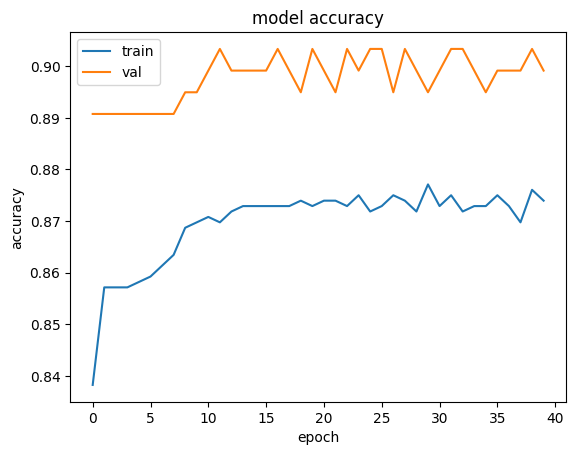

In [185]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

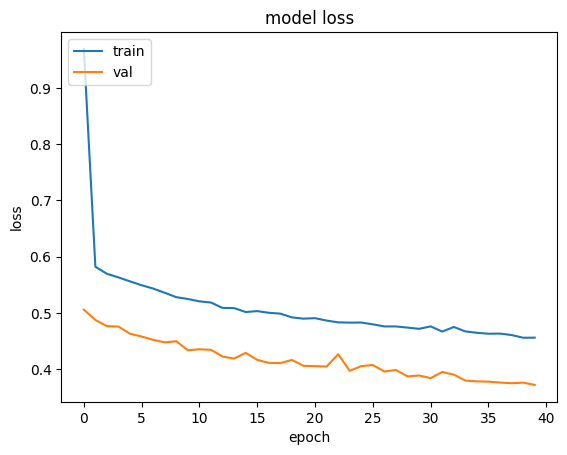

In [186]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [192]:
#Predicted Class for Each Individual is the max probability of the six classes [...] 
model.predict(x_train)

38/38 [==============================] - 0s 2ms/step


array([[7.8487360e-01, 1.0708234e-01, 1.7822195e-02, 8.6453790e-03,
        5.9339728e-02, 2.2236779e-02],
       [9.8704624e-01, 2.7285090e-03, 2.6253958e-03, 7.9039368e-04,
        5.2892338e-03, 1.5202654e-03],
       [9.7197509e-01, 6.7952676e-03, 5.1371721e-03, 1.5684832e-03,
        1.1334992e-02, 3.1891649e-03],
       ...,
       [9.3582231e-01, 2.7772149e-02, 6.0991477e-03, 3.0410499e-03,
        1.9671025e-02, 7.5943819e-03],
       [9.1780859e-01, 2.6295073e-02, 1.2216021e-02, 4.2839185e-03,
        2.9956127e-02, 9.4403811e-03],
       [8.8519323e-01, 4.6196725e-02, 1.2716155e-02, 5.5088997e-03,
        3.7420839e-02, 1.2964015e-02]], dtype=float32)

In [191]:
print(len(model.predict(x_train)))

38/38 [==============================] - 0s 1ms/step
1190


### Improved  Binary Model
** TO DO **

### Improved Multi-Class Model
** TO DO **

# Code Backlog -- THINGS I TRIED THAT DIDN'T DO ANYTHING

In [ ]:
# Let's manually do cross validation to see if we can find a good 
# combination of C (lasso regularization parameter) and n (KNN parameter)
# Can make a note that we tried this but it made very little difference


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

ns = [1, 3, 5, 10, 15, 20, 30, 50]
cs = [0.001, 0.01, 0.1, 1, 10]
n_repeats = 3

# Initialize a list to store results
results = []

def manual_cv_logreg(X, y, ns, cs, n_repeats): 
    for n in ns:
        for c in cs:
            print(f"n: {n}, c: {c}")    
            repeat_results = []  
            for repeat in range(n_repeats):
                #print(f"Repeat {repeat + 1}/{n_repeats}")
    
                # Create a KFold cross-validator with 'n_splits' folds
                kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
                # Initialize a list to store the cross-validation results for this repeat
                fold_results = []
    
                for train_idx, test_idx in kf.split(X):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                    # impute 
                    X_train_imputed = impute_values(X_train, n)
                    X_test_imputed = impute_values(X_test, n)

                    #train model
                    model = LogisticRegression(penalty = "l1", solver='liblinear')
                    model.fit(X_train_imputed, y_train)

                    # make predictions on test data
                    y_pred = model.predict(X_test_imputed)
    
                    # Calculate the accuracy or other evaluation metric
                    accuracy = accuracy_score(y_test, y_pred)
                    fold_results.append(accuracy)
    
                # Calculate the mean accuracy and standard deviation for this repeat
                mean_accuracy = sum(fold_results) / len(fold_results)
                std_accuracy = (sum((x - mean_accuracy) ** 2 for x in fold_results) / len(fold_results)) ** 0.5
    
                #print(f"Mean Accuracy: {mean_accuracy:.4f}")
                #print(f"Std. Deviation: {std_accuracy:.4f}\n")
    
                repeat_results.append(mean_accuracy)
    
            # Calculate the overall mean accuracy across repeats for this parameter combination
            overall_mean_accuracy = sum(repeat_results) / len(repeat_results)
            results.append((n, c, overall_mean_accuracy))
    
    # Find the best parameter combination
    best_params = max(results, key=lambda x: x[2])
    print(f"Best Parameters: Parameter 1 = {best_params[0]}, Parameter 2 = {best_params[1]}")
    return best_params


manual_cv_logreg(X_train, y_train['any_event'], ns, cs, n_repeats)

In [ ]:
# testing out a random forest model???
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_upsampled, y_train_upsampled['LET_IS'])
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test['LET_IS'], y_pred)
report = classification_report(y_test['LET_IS'], y_pred)

# our accuracy takes a hit, but we have better recall in four more classes. 
print(accuracy)
report_data = report.split('\n')
table = PrettyTable(["Category"] + report_data[0].split())
for line in report_data[2:-5]:
    table.add_row(line.split())
print(table)

In [ ]:
# multi-output regression
y_train_moutput = y_train[['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
       'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']]
y_test_moutput = y_test[['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
       'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']]

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report


logistic_reg = LogisticRegression(penalty = "l1", solver='liblinear')
multioutput_classifier = MultiOutputClassifier(logistic_reg)
multioutput_classifier.fit(X_train_imputed, y_train_moutput)


y_pred = multioutput_classifier.predict(X_test_imputed)
print("Accuracy:", accuracy_score(y_test_moutput, y_pred))
print("Classification Report:")
print(classification_report(y_test_moutput, y_pred))

